<a href="https://colab.research.google.com/github/MDankloff/ClusterCompas/blob/main/V2_COMPAS_Clustering_K_Means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [117]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
import os
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy import stats
from scipy.stats import ttest_ind

import warnings
warnings.filterwarnings('ignore')

In [118]:
data_shaperr = pd.read_csv('/content/Shap_error_data.csv')
data_shaperr.head()

,age,priors_count,sex_Female,sex_Male,race_African-American,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other,...,Shap_race_Native American,Shap_race_Other,predicted_class,true_class,errors,TP,TN,FN,FP,Error_Type
0,-0.746845,-0.094066,-0.494734,0.494734,0.981167,-0.067641,-0.716158,-0.313915,-0.052726,-0.239983,...,0.035609,-0.144069,0.0,0.0,0.0,0.0,1.0,0.0,0.0,TN
1,0.426714,0.111220,2.021287,-2.021287,-1.019194,-0.067641,-0.716158,3.185577,-0.052726,-0.239983,...,0.035609,0.275522,0.0,1.0,1.0,0.0,0.0,1.0,0.0,FN
2,-1.165973,-0.504638,-0.494734,0.494734,-1.019194,-0.067641,1.396340,-0.313915,-0.052726,-0.239983,...,0.035609,0.531565,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-0.746845,0.727079,-0.494734,0.494734,-1.019194,-0.067641,1.396340,-0.313915,-0.052726,-0.239983,...,0.035609,0.192882,1.0,0.0,1.0,0.0,0.0,0.0,1.0,FP
4,0.007586,-0.709925,2.021287,-2.021287,-1.019194,-0.067641,-0.716158,3.185577,-0.052726,-0.239983,...,0.035609,-0.221036,1.0,0.0,1.0,0.0,0.0,0.0,1.0,FP


# Data preparation

In [119]:
META_COL = ['predicted_class', 'true_class', 'errors', 'TP', 'TN', 'FN', 'FP', 'Error_Type', 'clusters', 'new_clusters']
SHAP_COL = ['Shap_age', 'Shap_priors_count' , 'Shap_sex_Female', 'Shap_sex_Male',
            'Shap_race_African-American', 'Shap_race_Asian', 'Shap_race_Caucasian', 'Shap_race_Hispanic',
            'Shap_race_Native American', 'Shap_race_Other']
BASIC_COL = ['age', 'priors_count', 'sex_Female', 'sex_Male', 'race_African-American', 'race_Asian', 'race_Caucasian',
             'race_Hispanic', 'race_Native American', 'race_Other', 'error_scaled' ]
META_COL_VIZ = ['predicted_class', 'true_class', 'TP', 'TN', 'FN', 'FP', 'error_scaled', 'Error_Type', 'new_clusters']
DUMMY_RACE = ['race_African-American', 'race_Asian', 'race_Caucasian',
             'race_Hispanic', 'race_Native American', 'race_Other']
SHORT_LABEL_RACE = ['Afr.Am.', 'Asian', 'Cauc.', 'Hisp.', 'Native', 'Other']
DUMMY_GENDER = ['sex_Female', 'sex_Male']
SHORT_LABEL_GENDER = ['Female', 'Male']

In [120]:
'''Drop rows where both TP and FN are 0 '''
def drop_zero_TP_FN(data):
    return data.loc[(data['TP'] == 1) | (data['FN'] == 1)]

'''Drop rows where both TN and FP are 0'''
def drop_zero_TN_FP(data):
    return data.loc[(data['TN'] == 1) | (data['FP'] == 1)]

TPFN_data = drop_zero_TP_FN(data_shaperr)
TNFP_data = drop_zero_TN_FP(data_shaperr)

#TNFP_data.head()
#TPFN_data.info()

In [121]:
'''Initialize dataset to scale the features and errors which can be in/excluded for clustering.
Returns a scaled dataset with new columns "clusters" = 0 and "new_clusters" = -1, which is required for HBAC '''

def initialize_dataset(data, with_errors=True, just_features=True, scale_features=True, with_classes=True, with_Dummy= True):
    new_data = data.copy(deep=True).dropna() #remove rows with NaN values

    #Seperate features before scaling
    features = new_data.drop(META_COL, errors='ignore')

    if with_errors:
        error_columns = ['TP', 'TN', 'FN', 'FP', 'errors']
        if all(col in new_data.columns for col in error_columns):
          new_data[error_columns] *= 0.8 #scaling factor

    if just_features: #Check if the columns exist before dropping:
      new_data = new_data.drop(columns=META_COL, errors = 'ignore')
      if 'clusters' in new_data.columns:
        new_data = new_data.drop('clusters', axis=1)
      if 'new_clusters' in new_data.columns:
        new_data = new_data.drop('new_clusters', axis=1)

    if scale_features:
      '''Ensure only numeric columns are scaled + try using minmax and standard scaler'''
      numeric_cols = features.select_dtypes(include=['number']).columns
      new_data[numeric_cols] = StandardScaler().fit_transform(features[numeric_cols])
      #new_data[numeric_cols] = MinMaxScaler().fit_transform(features[numeric_cols])

        #to_scale = features.columns
        #new_data[to_scale] = StandardScaler().fit_transform(features[to_scale])
        #new_data[to_scale] = MinMaxScaler().fit_transform(features[to_scale])

    if with_Dummy:
      for col in DUMMY_RACE + DUMMY_GENDER:
        if col in new_data.columns:
          one_hot = pd.get_dummies(new_data[col], prefix=col)
          new_data = new_data.drop(col, axis=1)
          new_data = pd.concat([new_data, one_hot], axis=1)

    if with_classes:
      for col in META_COL:
        if col in data.columns:
          new_data[col] = data[col]

    new_data['clusters'] = 0
    new_data['new_clusters'] = -1

    return new_data

In [122]:
'''undo Dummy for DUMMY_RACE or DUMMY_GENDER'''
def undo_dummy(data, with_Dummy, col_label, numeric_values=True, short_label=None):
  data[col_label] = ''
  for i, c in enumerate(with_Dummy):
    values = np.sort(data[c].unique())
    if numeric_values:
      data.loc[data[c] == values[1], col_label] = i
    else:
      if short_label is None:
        raise ValueError("short label must be provided if numeric_values is False")
        data.loc[data[c] == values[1], col_label] = short_label[i]
    data = data.drop(c, axis=1)
  return(data)

#data = undo_dummy(data, DUMMY_RACE, col_label='race', numeric_values=False, short_label=SHORT_LABEL_RACE)
#data = undo_dummy(data, DUMMY_GENDER, col_label='gender', numeric_values=False, short_label=SHORT_LABEL_GENDER)

In [123]:
#print(data_shaperr.shape)
#data_shaperr.head()
#data_shaperr.info()

# UTILS for BIAS in ERROR DIFFERENCE

In [124]:
#Calculate Error rate based on mean - replacing old accuracy_error()
def get_error_rate(data):
  if len(data) == 0:
    print ('calculating error rate on an empty cluster')
    return
  return data.loc[:, 'errors'].mean()

'''Calculate BIAS in terms of Error Difference
bias_type can be 'negative', 'positive' or 'absolute'
baseline can be 'all' which is the overall error rate, or 'other' or 'best' '''

def get_error_diff(data, cluster_id, cluster_col, bias_type = 'negative', baseline= 'all', full_info=False, function = get_error_rate):
  cluster_x= data.loc[data[cluster_col] == cluster_id]
  remaining_clusters = data.loc[data[cluster_col] != cluster_id]

  if len(cluster_x) == 0:
    print ('calculating error difference on an empty cluster')
    return

  if baseline == 'all':
    error_diff = get_error_rate(cluster_x) - get_error_rate(data)

  elif baseline == 'other':
    if len(remaining_clusters) == 0:
      print ("This cluster is the entire dataset. Cluster:", cluster_id)
      return
    error_diff = get_error_rate(cluster_x) - get_error_rate(remaining_clusters)

  #elif baseline == 'best':
    #best_cluster = get_cluster_w_min_bias(data, cluster_col, bias_type, baseline)
    #error_diff = get_error_rate(cluster_x) - best_cluster[1]
  else:
    print ('unknown baseline')
    return

  if full_info:
    return [error_diff, get_error_rate(cluster_x), get_error_rate(remaining_clusters)]

  if bias_type == 'negative':
    pass #no change needed
  elif bias_type == 'positive':
    error_diff = -error_diff
  elif bias_type == 'absolute':
    error_diff = np.absolute(error_diff)
  else:
    print("unknown bias type")
    return

  return error_diff

# UTILS for VISUALS

In [125]:
def pca_plot(data, title, alpha):
    # Extract features for PCA and drop Meta_colums
    pca_features = data.drop(META_COL, axis=1)
    other_features = data[META_COL]

    # Apply PCA with 2 components to scaled features and create a df for the resulting principal components
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(pca_features)
    pca_df = pd.DataFrame(pca_result, index=pca_features.index, columns=['PC1', 'PC2'])

    # Create temporary dataset that contains both principal components and other features
    temp_dataset = pca_df.join(other_features, how='left')

    # Create scatterplot using seaborn
    scatterplot = sns.scatterplot(data=temp_dataset, x='PC1', y='PC2', alpha=alpha, hue="clusters", palette='tab10', style='Error_Type')
    scatterplot.set_title(title)
    scatterplot.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)

    explained_variance_ratio = pca.explained_variance_ratio_
    print(f"Explained Variance Ratio: PC1 = {explained_variance_ratio[0]:.2f}, PC2 = {explained_variance_ratio[1]:.2f}")

    plt.show()

def tsne_plot(data, title, perplexity, learning_rate, n_iter, alpha = 0.5):
    # Extract features for TSNE and drop Meta_colums
    tsne_features = data.drop(META_COL, axis=1)
    other_features = data[META_COL]

    tsne = TSNE(n_components=2, perplexity= 30, learning_rate= 200, n_iter= 1000)
    tsne_result = tsne.fit_transform(tsne_features)
    tsne_df = pd.DataFrame(tsne_result, index = tsne_features.index, columns=['t-SNE Component 1', 't-SNE Component 2'])

    temp_dataset = tsne_df.join(other_features, how='left')

    # Create scatterplot using seaborn
    scatterplot = sns.scatterplot(data=temp_dataset, x='t-SNE Component 1', y='t-SNE Component 2', alpha=alpha, hue="clusters", palette='tab10', style='Error_Type')
    scatterplot.set_title(title)
    scatterplot.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)

    plt.show()


# UTILS FOR CLUSTERING

In [126]:
#get cluster with max error difference
def get_max_bias_cluster(data, cluster_col= 'clusters', bias_type = 'negative', baseline = 'all', function = get_error_diff):
  max_bias = 0
  max_bias_cluster = -2
  full_info = [0,0,0]
  for cluster_id in data[cluster_col].unique():
    if cluster_id == -1: #outliers in dbscan
      continue
    current_bias = get_error_diff(data, cluster_id, cluster_col, bias_type, baseline, full_info) #pos function to find highest bias
    if current_bias > max_bias:
      max_bias = current_bias
      max_bias_cluster = cluster_id

      full_info = get_error_diff(data,cluster_id,cluster_col, bias_type, baseline, full_info= True)
      return(max_bias_cluster, full_info[0])


#get cluster with min error difference
def get_min_bias_cluster(data, cluster_col= 'clusters', bias_type = 'negative', baseline = 'all'):
  min_bias = 1
  min_bias_cluster = -2
  full_info = [0,0,0]

  for cluster_id in data[cluster_col].unique():
    if cluster_id == -1: #outliers in dbscan
      continue
    current_bias = get_error_diff(data, cluster_id, cluster_col, bias_type, baseline, full_info) #
    if current_bias < min_bias:
      min_bias = current_bias
      min_bias_cluster = cluster_id

  full_info = get_error_diff(data,cluster_id,cluster_col, bias_type, baseline, full_info= True)
  return(min_bias_cluster, full_info[0])

#get size of the smallest cluster
def get_min_cluster_size(data, cluster_col = 'new_clusters'):
  min_cluster_size = len(data)
  for i in data['new_clusters'].unique():
    if i == -1: #exclude the -1 clusters as they may present outliers (in dbscan?)
      continue
      size = len(data.loc[data['new_clusters'] == i])
      if size < min_cluster_size: #update if new cluster size is smaller
        min_cluster_size = size
  return(min_cluster_size)

def get_random_cluster(data, cluster_col, min_splittable_cluster_size, previous_cluster, all_cluster_ids):
  for candidate_cluster_id in all_cluster_ids:
    if candidate_cluster_id == -1 or candidate_cluster_id == previous_cluster:
      continue
      print ('This is the random cluster we picked:', candidate_cluster_id)

      candidate_cluster = data.loc[data[cluster_col] == candidate_cluster_id]
      if len(candidate_cluster) >= min_splittable_cluster_size:
        print('it is too small:', len(candidate_cluster))
        continue
      else:
        return candidate_cluster_id

def select_new_cluster(data, cluster_col='clusters', error_column='errors', overall_error_rate=0.5, bias_type='negative', baseline='all'):
    smallest_diff = float('inf')
    selected_cluster = None

    for cluster_id in data[cluster_col].unique():
        if cluster_id == -1: #skip outlier
            continue

        error_diff = get_error_diff(data, cluster_id, cluster_col, bias_type, baseline) #calculate the error_diff for each cluster

        if error_diff is None:
            continue

        abs_diff = abs(overall_error_rate - (get_error_rate(data[data[cluster_col] == cluster_id]))) #get cluster with the smallest absolute difference with the overall error rate (0.5)

        if abs_diff < smallest_diff:
            smallest_diff = abs_diff
            selected_cluster = cluster_id
    return selected_cluster

def exit_clustering(data, msg='', bias_type='', iter=''):
  print('Iteration ', iter, ': ', msg)
  print('Overall error rate: ', get_error_rate(data))
  for c in np.sort(data['clusters'].unique()):
    print('Cluster: ', c, '\tSize: ', len(data.loc[data['clusters'] == c]), '\tError rate: ', get_error_rate(data.loc[data['clusters'] == c]))
  pca_plot(data,'HBAC-DBSCAN on COMPAS - ' + bias_type + ' bias', hue='clusters', s=15, alpha=0.8)
  return data


# K-MEANS CLUSTERING

In [127]:
clus_model_kwargs = { "n_clusters": 2, #split in two clusters
    "init": "k-means++", # method for initializing k-means++: first centroid is chosen randomly and subsequent centriods are selected based on max distance from the nearest centriod
    "n_init": 10, #K-means is sensitive to the initial placement of cluster centers - running it 10 times with different initial seeds
    "max_iter": 300,} #max mr of iterations for k-means in a single run. If convergence is not achieved within 300 the algorithm stops

In [130]:
print(TPFN_data.dtypes)

age                           float64
priors_count                  float64
sex_Female                    float64
sex_Male                      float64
race_African-American         float64
race_Asian                    float64
race_Caucasian                float64
race_Hispanic                 float64
race_Native American          float64
race_Other                    float64
Shap_age                      float64
Shap_priors_count             float64
Shap_sex_Female               float64
Shap_sex_Male                 float64
Shap_race_African-American    float64
Shap_race_Asian               float64
Shap_race_Caucasian           float64
Shap_race_Hispanic            float64
Shap_race_Native American     float64
Shap_race_Other               float64
predicted_class               float64
true_class                    float64
errors                        float64
TP                            float64
TN                            float64
FN                            float64
FP          

Explained Variance Ratio: PC1 = 0.19, PC2 = 0.13


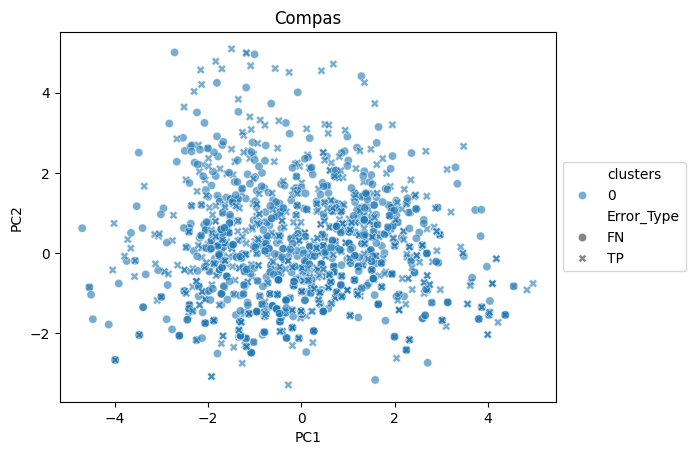

In [129]:
TP_FN = initialize_dataset(TPFN_data)
pca_plot(TP_FN, 'Compas', 0.6)

Explained Variance Ratio: PC1 = 0.19, PC2 = 0.14


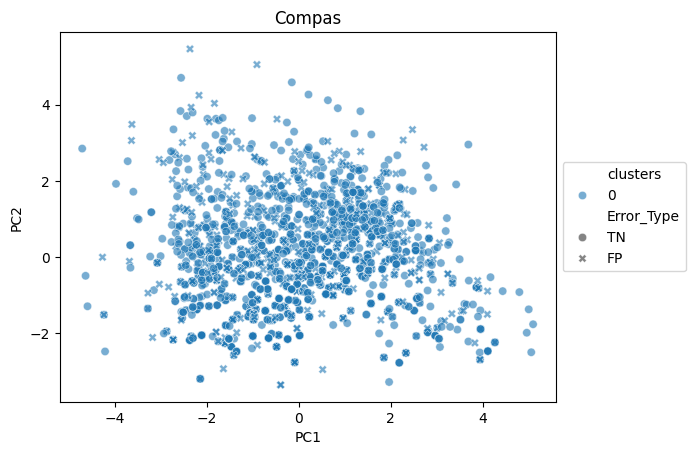

In [131]:
TN_FP = initialize_dataset(TNFP_data)
pca_plot(TN_FP, 'Compas', 0.6)

# ANOVA SIGNIFICANCE TESTING